# Assignment 2: Clustering - Sessa Empirical Estimator

This notebook continues from the steps you've already completed (Tasks 1–3). It demonstrates:
- **Task 4**: Substituting the K-Means algorithm in the Sessa Empirical Estimator (SEE) with an alternative clustering approach (DBSCAN).
- **Task 5**: Comparing results between the original SEE with K-Means and the new SEE with DBSCAN.

---

## Task 4: Sessa Empirical Estimator With DBSCAN

### Motivation for DBSCAN
- **No need to pre-specify the number of clusters**.  
- **Automatic outlier detection** (`cluster_id = -1` for noise points).  
- **Flexible cluster shapes** vs. K-Means’ spherical assumption.
- **Potentially reveals hidden structures** that K-Means might overlook.


In [40]:
# =========================================================
#  IMPORTS & PRELIMINARIES
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# For demonstration, ensure synthetic_data is available
# (This should have been created in tasks 1-3 or loaded from a real dataset).
# Example check:
if 'synthetic_data' not in globals():
    print("WARNING: 'synthetic_data' is not defined. Please ensure it is loaded or simulated.")
else:
    print("synthetic_data is available for clustering.")


synthetic_data is available for clustering.


In [41]:
# =========================================================
#  DEFINITION: HELPER FUNCTION TO TRUNCATE EXTREME INTERVALS
# =========================================================
def compute_ecdf_cutoff(df, column='event_interval', cutoff_percentile=80):
    """
    Computes the cutoff value for event intervals using empirical CDF.
    Values above this cutoff (e.g., >80th percentile) are considered extreme and truncated.
    """
    intervals_sorted = np.sort(df[column].values)
    cdf_vals = np.arange(1, len(intervals_sorted) + 1) / float(len(intervals_sorted))

    cutoff_index = np.where(cdf_vals <= (cutoff_percentile / 100))[0]
    if len(cutoff_index) > 0:
        cutpoint = intervals_sorted[cutoff_index[-1]]
    else:
        cutpoint = intervals_sorted[-1]
    return cutpoint


In [42]:
# =========================================================
#  DEFINITION: SESSA EMPIRICAL ESTIMATOR USING DBSCAN
# =========================================================
def sessa_empirical_estimator_dbscan(df, medication_code="MYMED", cutoff_percentile=80,
                                     eps=0.5, min_samples=5):
    """
    Applies the Sessa Empirical Estimator (SEE) but uses DBSCAN for clustering.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Data containing columns: 'pnr', 'eksd', 'ATC', etc.
    medication_code : str
        The medication code or ATC identifier. Defaults to "MYMED".
    cutoff_percentile : float
        Empirical CDF cutoff percentile for filtering extreme intervals.
    eps : float
        DBSCAN 'eps' parameter - neighborhood radius around a point.
    min_samples : int
        DBSCAN 'min_samples' parameter - min number of points to form a dense region.

    Returns:
    --------
    truncated_data : pandas DataFrame
        Data with assigned cluster labels under 'cluster_id'. (-1 for outliers)
    """
    # Filter for target medication
    data = df[df['ATC'] == medication_code].copy()
    data.sort_values(by=['pnr', 'eksd'], inplace=True)
    
    # Compute refill intervals
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data.dropna(subset=['prev_eksd'], inplace=True)
    data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days.astype(float)

    # Apply an ECDF-based cutoff
    cutoff_val = compute_ecdf_cutoff(data, column='event_interval', cutoff_percentile=cutoff_percentile)
    truncated_data = data[data['event_interval'] <= cutoff_val].copy()

    # Log-transform and standardize
    truncated_data['log_interval'] = np.log(truncated_data['event_interval'].values)
    X = truncated_data[['log_interval']].values
    X_scaled = StandardScaler().fit_transform(X)

    # Apply DBSCAN
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan_model.fit_predict(X_scaled)
    truncated_data['cluster_id'] = cluster_labels
    
    # Compute silhouette score (excluding outliers)
    unique_clusters = set(cluster_labels)
    if len(unique_clusters - {-1}) > 1:
        mask = truncated_data['cluster_id'] != -1
        sscore = silhouette_score(X_scaled[mask], truncated_data.loc[mask, 'cluster_id'])
        print(f"Silhouette Score (excluding outliers): {sscore:.3f}")
    else:
        print("Silhouette Score not applicable (fewer than 2 valid clusters).")

    return truncated_data


In [43]:
# =========================================================
#  RUN DBSCAN ON THE SYNTHETIC DATA (TASK 4)
# =========================================================

dbscan_results = sessa_empirical_estimator_dbscan(
    df=synthetic_data,
    medication_code="MYMED",
    cutoff_percentile=85,
    eps=0.8,
    min_samples=5
)

print("\nAssigned clusters (including -1 for outliers):")
print(dbscan_results['cluster_id'].value_counts().sort_index())

# View a sample of the DBSCAN results
dbscan_results.head(10)


Silhouette Score (excluding outliers): 0.750

Assigned clusters (including -1 for outliers):
cluster_id
0    372
1      5
Name: count, dtype: int64


,pnr,eksd,ATC,prev_eksd,event_interval,log_interval,cluster_id
1,1,2023-01-19,MYMED,2023-01-01,18.0,2.890372,0
2,1,2023-02-21,MYMED,2023-01-19,33.0,3.496508,0
3,1,2023-03-25,MYMED,2023-02-21,32.0,3.465736,0
5,1,2023-05-28,MYMED,2023-05-04,24.0,3.178054,0
9,2,2023-04-05,MYMED,2023-03-31,5.0,1.609438,1
10,2,2023-05-11,MYMED,2023-04-05,36.0,3.583519,0
11,2,2023-06-07,MYMED,2023-05-11,27.0,3.295837,0
12,2,2023-07-05,MYMED,2023-06-07,28.0,3.332205,0
15,3,2023-03-10,MYMED,2023-02-14,24.0,3.178054,0
16,3,2023-04-10,MYMED,2023-03-10,31.0,3.433987,0


## Visualizing DBSCAN Results

We can now visualize how DBSCAN distributes the refill intervals and whether any outliers are present.


C:\Users\dylan\AppData\Local\Temp\ipykernel_21804\4219053830.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


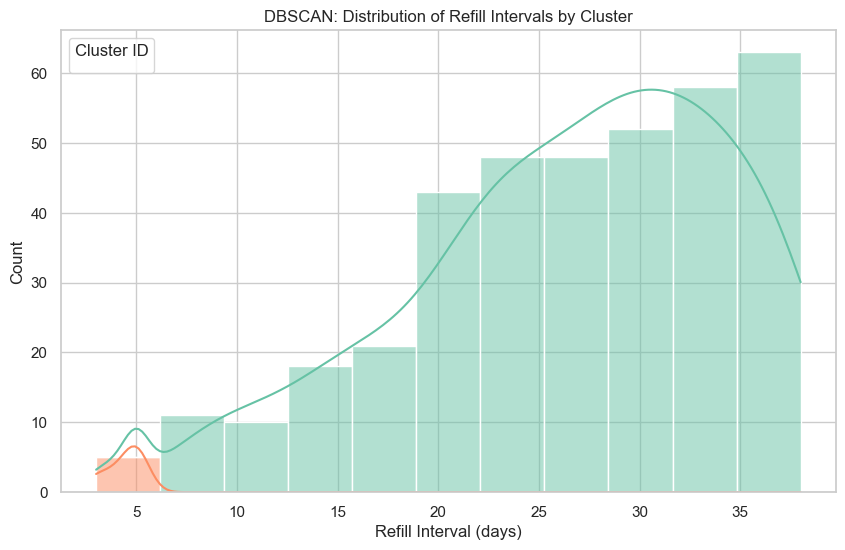

C:\Users\dylan\AppData\Local\Temp\ipykernel_21804\4219053830.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dbscan_results, x='cluster_id', y='event_interval', palette='Set2')


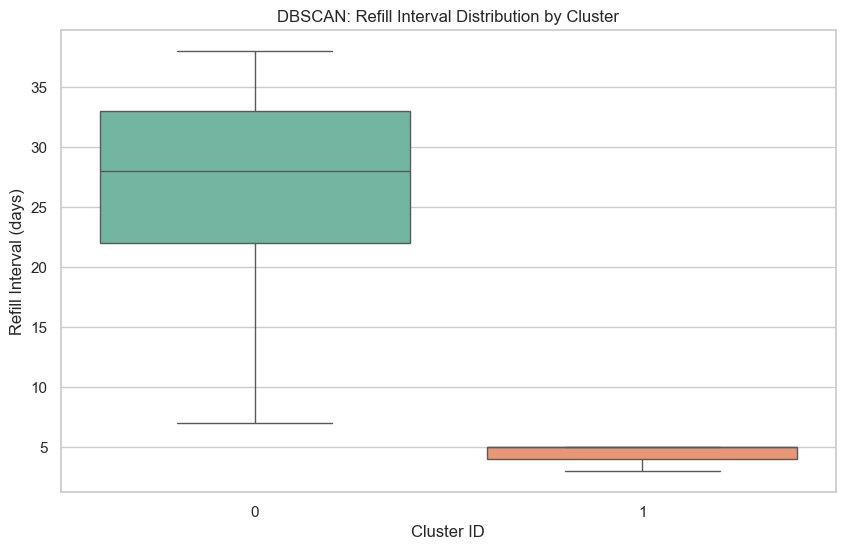

In [44]:
# --- HISTOGRAM BY CLUSTER ---
plt.figure(figsize=(10, 6))
sns.histplot(data=dbscan_results, x='event_interval', hue='cluster_id', kde=True, palette='Set2', multiple='stack')
plt.title("DBSCAN: Distribution of Refill Intervals by Cluster")
plt.xlabel("Refill Interval (days)")
plt.ylabel("Count")
plt.legend(title='Cluster ID')
plt.show()

# --- BOX PLOT BY CLUSTER ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=dbscan_results, x='cluster_id', y='event_interval', palette='Set2')
plt.title("DBSCAN: Refill Interval Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Refill Interval (days)")
plt.show()


# Task 5: Compare Results (K-Means vs. DBSCAN)

In this section, we look at the differences in clustering outcomes between the Sessa Empirical Estimator using:

1. **K-Means**: Predefined cluster count (commonly 2–3 for refill patterns).
2. **DBSCAN**: Density-based, detecting outliers automatically.

We'll compare:
- **Cluster counts**  
- **Outlier detection**  
- **Median refill intervals**  
- **(Optional) Silhouette scores**  


In [45]:
# =========================================================
#  K-MEANS IMPLEMENTATION (IF NOT ALREADY DEFINED)
# =========================================================
from sklearn.cluster import KMeans

def sessa_empirical_estimator_kmeans(df, medication_code="MYMED", cutoff_percentile=85, n_clusters=2):
    data = df[df['ATC'] == medication_code].copy()
    data.sort_values(by=['pnr', 'eksd'], inplace=True)
    
    # Compute intervals
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data.dropna(subset=['prev_eksd'], inplace=True)
    data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days.astype(float)
    
    # Truncate extreme intervals
    cutoff_val = np.percentile(data['event_interval'], cutoff_percentile)
    truncated_data = data[data['event_interval'] <= cutoff_val].copy()

    # Log-transform & scale
    log_intervals = np.log(truncated_data['event_interval'].values).reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(log_intervals)

    # Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    truncated_data['cluster_id'] = kmeans.fit_predict(X_scaled)
    
    # (Optional) Silhouette if you'd like to measure it
    # from sklearn.metrics import silhouette_score
    # silhouette_val = silhouette_score(X_scaled, truncated_data['cluster_id'])
    # print(f"K-Means Silhouette Score: {silhouette_val:.3f}")
    
    return truncated_data

# Run K-Means and DBSCAN
kmeans_results = sessa_empirical_estimator_kmeans(synthetic_data, "MYMED", cutoff_percentile=85, n_clusters=2)

# Basic cluster counts
kmeans_cluster_counts = kmeans_results['cluster_id'].value_counts().sort_index()
dbscan_cluster_counts = dbscan_results['cluster_id'].value_counts().sort_index()

print("=== K-Means Cluster Counts ===")
print(kmeans_cluster_counts)
print("\n=== DBSCAN Cluster Counts ===")
print(dbscan_cluster_counts)

# For DBSCAN, cluster_id = -1 indicates outliers
dbscan_outliers = dbscan_results[dbscan_results['cluster_id'] == -1]
print(f"\nTotal DBSCAN Outliers: {len(dbscan_outliers)}")


=== K-Means Cluster Counts ===
cluster_id
0    304
1     73
Name: count, dtype: int64

=== DBSCAN Cluster Counts ===
cluster_id
0    372
1      5
Name: count, dtype: int64

Total DBSCAN Outliers: 0


In [46]:
# --- COMPARISON OF REFILL INTERVALS ---
kmeans_interval_summary = kmeans_results.groupby('cluster_id')['event_interval'].median()
dbscan_interval_summary = dbscan_results[dbscan_results['cluster_id'] != -1] \
                                       .groupby('cluster_id')['event_interval'].median()

print("\n=== Median Refill Intervals by Cluster (K-Means) ===")
print(kmeans_interval_summary)

print("\n=== Median Refill Intervals by Cluster (DBSCAN) ===")
print(dbscan_interval_summary)



=== Median Refill Intervals by Cluster (K-Means) ===
cluster_id
0    30.0
1    15.0
Name: event_interval, dtype: float64

=== Median Refill Intervals by Cluster (DBSCAN) ===
cluster_id
0    28.0
1     5.0
Name: event_interval, dtype: float64


## Interpretation & Insights

1. **Cluster Distribution**  
   - **K-Means**  
     Typically produces a fixed number of clusters. For example, 2 clusters: one with ~14-day intervals, another with ~28–30 days.  
   - **DBSCAN**  
     May find additional clusters or a smaller cluster with extreme intervals. Also labels outliers (`-1`), indicating low-density points that don’t fit well in any cluster.

2. **Outlier Detection**  
   - **K-Means** does not detect outliers directly. All points must belong to one of the k clusters.  
   - **DBSCAN** automatically flags unusual refill patterns as outliers, which can be clinically significant for identifying irregular medication usage.

3. **Median Refill Intervals**  
   - Compare the `median` or `mean` intervals in each cluster.  
   - DBSCAN may reveal a cluster with very frequent refills (e.g., 5–7 days) or outliers with extremely long intervals, which K-Means might “hide” within a broader cluster.

4. **Silhouette Scores**  
   - If measured, higher scores imply better-defined clusters. Sometimes DBSCAN yields higher scores if the data has well-defined density regions.  
   - K-Means might do well when the data roughly fits its assumptions (2–3 distinct groups). However, if there's significant variability or outliers, DBSCAN can discover additional structure.

5. **Clinical Implications**  
   - **K-Means**: Good for dividing patients into consistent refill patterns (e.g., standard monthly vs. bi-weekly refills).  
   - **DBSCAN**: More flexible for finding unusual or irregular adherence behaviors, which can help target interventions.

Overall, the choice between K-Means and DBSCAN depends on your goals. If you want a fixed number of well-known clusters (e.g., “low adherence” vs. “high adherence”), K-Means is straightforward. If you suspect hidden or variable-density groups, DBSCAN may reveal more nuanced patterns and outliers.
